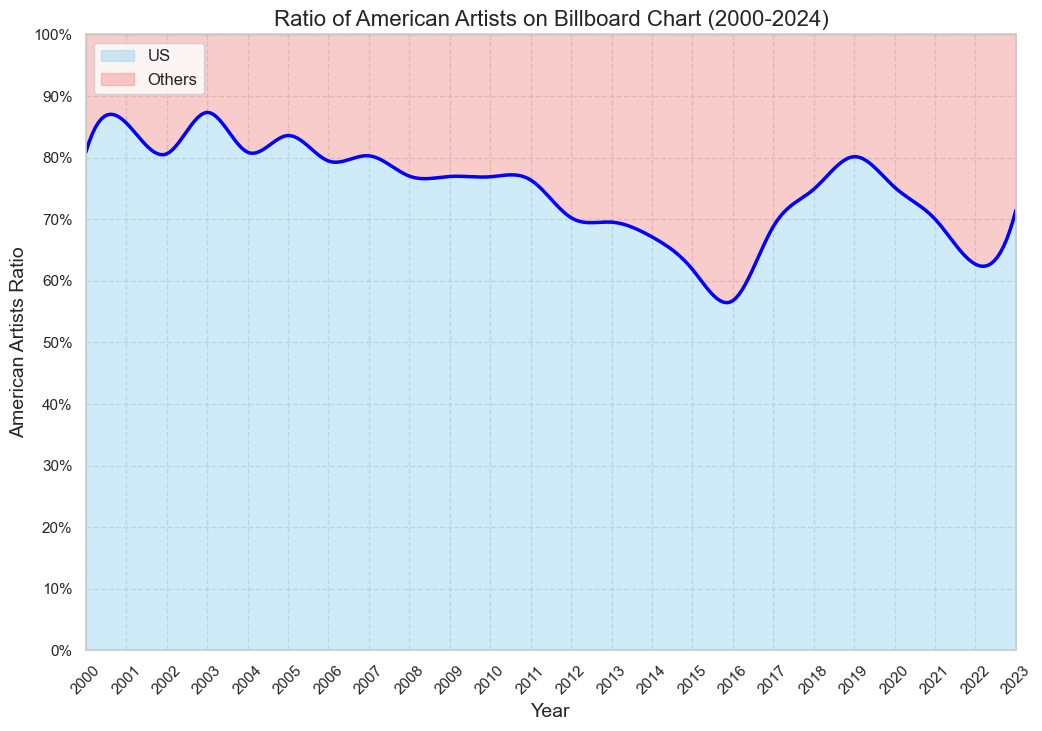

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# 데이터 불러오기
billboard_df = pd.read_csv('billboard_24years_lyrics_spotify.csv')
artist_countries_df = pd.read_csv('artist_countries.csv')

# 2000년 이후 데이터 필터링
billboard_df = billboard_df[billboard_df['year'] >= 2000]

# 데이터셋 병합
merged_df = pd.merge(billboard_df, artist_countries_df, left_on='band_singer', right_on='Artist', how='left')

# 미국 국적 가수 필터링
merged_df['is_american'] = merged_df['Country'] == 'US'

# 연도별 미국 국적 가수 비율 계산
grouped = merged_df.groupby('year').agg(
    total_artists=('band_singer', 'count'),
    american_artists=('is_american', 'sum')
)
grouped['american_ratio'] = grouped['american_artists'] / grouped['total_artists']

# 데이터 보간 (smoothing)
x = grouped.index
y = grouped['american_ratio']
x_smooth = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(x_smooth)

# Seaborn 스타일 설정
sns.set(style='whitegrid', palette='pastel')

# 그래프 그리기
plt.figure(figsize=(12, 8))

# 면적 채우기
plt.fill_between(x_smooth, y_smooth, color="skyblue", alpha=0.4, label='US')
plt.fill_between(x_smooth, y_smooth, 1, color="lightcoral", alpha=0.4, label='Others')

# 부드러운 선 그래프 그리기
plt.plot(x_smooth, y_smooth, color="blue", linewidth=2.5)

# 그래프 제목과 축 레이블 추가
plt.title('Ratio of American Artists on Billboard Chart (2000-2024)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('American Artists Ratio', fontsize=14)

# 축 범위 설정 및 그리드 표시
plt.xlim(2001, 2022)  # 연도 범위 조정
plt.ylim(0, 1)
plt.xticks(grouped.index, rotation=45)
plt.yticks([i/10 for i in range(0, 11)], [f'{i*10}%' for i in range(0, 11)])
plt.grid(True, linestyle='--', alpha=0.7)

# 범례 추가
plt.legend(loc='upper left', fontsize=12)

# 그래프 출력
plt.show()


In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bar_chart_race as bcr
import tempfile
import os
import plotly.express as px
from scipy.interpolate import make_interp_spline
import numpy as np


@st.cache_data
def load_and_process_data():
    # 데이터 로드 및 전처리
    df = pd.read_csv('1jo/artist_countries.csv', encoding='latin1')
    df_full = pd.read_csv('1jo/billboard_24years_lyrics_spotify.csv', encoding='latin1')
    
    df_full = pd.merge(df_full, df, left_on='band_singer', right_on='Artist', how='left')
    df_full.drop(columns=['Artist'], inplace=True)
    
    country_dict = {
        'US': 'United States',
        'GB': 'United Kingdom',
        'CU': 'Cuba',
        'FR': 'France',
        'JM': 'Jamaica',
        'ES': 'Spain',
        'CA': 'Canada',
        'NZ': 'New Zealand',
        'NG': 'Nigeria',
        'DK': 'Denmark',
        'AU': 'Australia',
        'JP': 'Japan',
        'BE': 'Belgium',
        'CO': 'Colombia',
        'NL': 'Netherlands',
        'UK': 'United Kingdom',
        'SE': 'Sweden',
        'DZ': 'Algeria',
        'HT': 'Haiti',
        'VE': 'Venezuela',
        'KR': 'South Korea',
        'DE': 'Germany',
        'IN': 'India',
        'IT': 'Italy',
        'GY': 'Guyana',
        'AT': 'Austria',
        'RO': 'Romania',
        'NO': 'Norway',
        'PR': 'Puerto Rico',
        'IE': 'Ireland',
        'VC': 'Saint Vincent',
        'MX': 'Mexico',
        'IS': 'Iceland',
        'BB': 'Barbados',
        'XG': 'United States',
        'VG': 'British Virgin Islands',
        'PH': 'Philippines',
        'SN': 'Senegal',
        'AR': 'Argentina',
        'PK': 'Pakistan'
    }
    
    df_full['Country Full Name'] = df_full['Country'].map(country_dict)
    
    cols = df_full.columns.tolist()
    band_singer_index = cols.index('band_singer')
    cols.insert(band_singer_index + 1, cols.pop(cols.index('Country')))
    df_full = df_full[cols]
    
    return df_full

@st.cache_data
def generate_bar_chart_race(df_bcr):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".mp4") as tmpfile:
        bcr.bar_chart_race(
            df=df_bcr,
            filename=tmpfile.name,
            orientation='h',
            sort='desc',
            n_bars=len(df_bcr.columns),
            fixed_order=False,
            fixed_max=True,
            steps_per_period=30,
            interpolate_period=True,
            label_bars=True,
            bar_size=.90,
            period_length=1000,
            figsize=(6, 5),
            cmap='tab20b',
            title='Bar Chart Race of Artist Counts (Excluding USA)',
            bar_label_size=7,
            tick_label_size=7,
            scale='linear',
            period_fmt=' ',
            period_summary_func=lambda v, r: {'x': .95, 'y': .80,
                                              's': f'{int(r.name)}',
                                              'ha': 'right', 'size': 20, 'weight': 'bold', 'color': 'blue'}
        )
        return tmpfile.name

def app():
    # 데이터 로드 및 전처리
    df_full = load_and_process_data()
    
    st.title('Billboard Artists Nationality Visualization')
    st.markdown("""
        This app visualizes the nationality of artists from Billboard data over 24 years.
    """)

    # 데이터 불러오기
    billboard_df = pd.read_csv('1jo/billboard_24years_lyrics_spotify.csv')
    artist_countries_df = pd.read_csv('1jo/artist_countries.csv')
    
    # 2000년 이후 데이터 필터링
    billboard_df = billboard_df[billboard_df['year'] >= 2000]
    
    # 데이터셋 병합
    merged_df = pd.merge(billboard_df, artist_countries_df, left_on='band_singer', right_on='Artist', how='left')
    
    # 미국 국적 가수 필터링
    merged_df['is_american'] = merged_df['Country'] == 'US'
    
    # 연도별 미국 국적 가수 비율 계산
    grouped = merged_df.groupby('year').agg(
        total_artists=('band_singer', 'count'),
        american_artists=('is_american', 'sum')
    )
    grouped['american_ratio'] = grouped['american_artists'] / grouped['total_artists']
    
    # 데이터 보간 (smoothing)
    x = grouped.index
    y = grouped['american_ratio']
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=3)
    y_smooth = spl(x_smooth)
    
    # Seaborn 스타일 설정
    sns.set(style='whitegrid', palette='pastel')
    
    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(12, 8))  # 서브플롯 생성
    
    # 면적 채우기
    ax.fill_between(x_smooth, y_smooth, color="skyblue", alpha=0.4, label='US')
    ax.fill_between(x_smooth, y_smooth, 1, color="lightcoral", alpha=0.4, label='Others')
    
    # 부드러운 선 그래프 그리기
    ax.plot(x_smooth, y_smooth, color="blue", linewidth=2.5)
    
    # 그래프 제목과 축 레이블 추가
    ax.set_title('Ratio of American Artists on Billboard Chart (2000-2024)', fontsize=16)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('American Artists Ratio', fontsize=14)
    
    # 축 범위 설정 및 그리드 표시
    ax.set_xlim(2001, 2022)  # 연도 범위 조정
    ax.set_ylim(0, 1)
    ax.set_xticks(grouped.index)
    ax.set_xticklabels(grouped.index, rotation=45)
    ax.set_yticks([i/10 for i in range(0, 11)])
    ax.set_yticklabels([f'{i*10}%' for i in range(0, 11)])
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 범례 추가
    ax.legend(loc='upper left', fontsize=12)
    
    # Streamlit에 그래프 출력
    st.pyplot(fig)

    # (이하 다른 코드들 그대로 유지)



In [ ]:
# 연도별 국가별 아티스트 수 계산
    df_full_year = df_full.copy()
    band_singer_index = df_full_year.columns.tolist().index('band_singer')
    cols = df_full_year.columns.tolist()
    cols.insert(band_singer_index + 2, cols.pop(cols.index('year')))
    df_full_year = df_full_year[cols]
    
    year_country_grouped = df_full_year.groupby(['year', 'Country Full Name']).size().unstack(fill_value=0)
    
    # 첫 번째 그래프: 국가별 연도별 아티스트 수 (전체)
    st.header('Number of Artists by Country and Year (Excluding USA)')
    year_country_grouped_excl_us = year_country_grouped.drop(columns='United States')
    
    fig, ax = plt.subplots(figsize=(15, 10))
    year_country_grouped_excl_us.plot(kind='barh', stacked=True, figsize=(15, 10), cmap='tab20', ax=ax)
    ax.set_xlabel('Number of Artists')
    ax.set_ylabel('Country')
    ax.set_title('Number of Artists by Country and Year (Excluding USA)')
    ax.invert_yaxis()
    st.pyplot(fig)
    
    # 두 번째 그래프: 특정 국가 선택
    st.header('Number of Artists by Selected Countries and Year (Excluding USA)')
    countries = st.multiselect(
        'Select countries to display', 
        options=year_country_grouped_excl_us.columns.tolist(),
        default=['United Kingdom', 'Canada', 'Australia']
    )
    
    if countries:
        selected_data = year_country_grouped_excl_us[countries]
        fig, ax = plt.subplots(figsize=(15, 10))
        selected_data.plot(kind='barh', stacked=True, figsize=(15, 10), cmap='tab20', ax=ax)
        ax.set_xlabel('Number of Artists')
        ax.set_ylabel('Country')
        ax.set_title(f'Number of Artists by Selected Countries and Year (Excluding USA)')
        ax.invert_yaxis()
        st.pyplot(fig)
    else:
        st.write("Please select at least one country.")
    
    # 바 차트 레이스
    st.header('Bar Chart Race of Artist Counts (Excluding USA)')
    artist_count_by_year_country = df_full_year.groupby(['year', 'Country Full Name'])['band_singer'].nunique().unstack(fill_value=0)
    df_bcr = artist_count_by_year_country.drop(columns='United States')
    
    if st.button('Show Bar Chart Race'):
        video_file = generate_bar_chart_race(df_bcr)
        st.video(video_file)
    
    # 도넛 차트
    st.header('Number of Artists by Country (Donut Chart, Excluding USA, UK, Canada)')
    grouped = df_full_year.groupby('Country Full Name').size().reset_index(name='Artist Count')
    grouped_excl_countries = grouped[~grouped['Country Full Name'].isin(['United States', 'United Kingdom', 'Canada'])]
    
    grouped_excl_countries['Percentage'] = (grouped_excl_countries['Artist Count'] / grouped_excl_countries['Artist Count'].sum()) * 100
    
    grouped_excl_countries['Label'] = grouped_excl_countries.apply(
        lambda row: row['Country Full Name'] if row['Percentage'] >= 2 else 'Others', axis=1
    )
    
    fig = px.pie(
        grouped_excl_countries,
        values='Artist Count',
        names='Label',
        hover_name='Country Full Name',
        title='Number of Artists by Country (Excluding USA, UK, Canada)',
        hole=0.4
    )
    
    fig.update_layout(
        width=800,
        height=600
    )
    
    st.plotly_chart(fig, use_container_width=True)
